# Nuoseklių sakinių klasifikavimas atsitiktinių imčių medicininių tyrimų santraukose

---

## Santrauka

**Tikslas:** sukurti natūralios kalbos apdorojimo (*Natural Language Processing*, **NLP**) modelį, kuris palengvintų medicininių tyrimų publikacijų santraukų skaitymą.

**Metodas:** eksperimentavimas sudarant ir mokinant mašininio bei gilaus mokymo modelius:
| Nr. | Pavadinimas | Tipas |
|:---:|:-------------:|-------|
|0|Bazinis modelis|TF-IDF Multinomial Naive Bayes classifier|
|1|Modelis 1|Conv1D with token embedding|
|2|Modelis 2|Feature extraction with pretrained token embeddings|
|3|Modelis 3|Conv1D with characters embedding|
|4|Modelis 4||
|5|Modelis 5||


**Rezultatas:** TODO

**Išvada:** TODO

### Bibliotekų importavimas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

2023-03-17 13:57:27.857715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# išjungiam TensorFlow įspėjimų (warnings) vaizdavimą rezultatuose
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Įvadas

Kiekvienais metais publikuojamų medicininių tyrimų skaičius tik auga, todėl medicinos specialistams tampa vis sunkiau greitai aptikti jiems reikiamą informaciją. Tyrinėtojai nagrinėdami ankstesnes publikacijas, dažniausiai perskaito tik santraukas, norėdami greitai patikrinti, ar straipsniai atitinka jų kriterijus. Šis procesas yra lengvesnis ir greitesnis jei santrauka yra **struktūrizuota**, t.y. padalinima į semantines antraštes (etikėtes), tokias kaip **tikslas, metodas, rezultatas ir išvada**. 

Kiekvieno santraukos sakinio suskirstymas į atitinkamą antraštę vadinamas nuoseklių sakinių klasifikavimu. Šiai  užduočiai atlikti šiame darbe įgyvendinama dirbtinio neuroninio tinklo (*artificial neural network*, **ANN**) modeliu pagrįsta sistema.

Darbas atliekamas remiantis **Franck Dernoncourt**, **Ji Young Lee** ir **Peter Szolovits** 2017 metų publikacija "[**Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**](https://arxiv.org/pdf/1612.05251)".

Neuroninių modelių kūrimui naudojama atviro kodo mašininio mokymo ir dirbtinio intelekto biblioteka [**Google TensorFlow**](https://www.tensorflow.org/).

---

## Duomenų rinkinys (*angl. dataset*)


[**PubMed 200k RCT**](https://arxiv.org/pdf/1710.06071.pdf) duomenų rinkinys sudaryta iš viešai prieinamos bibliotekos [PubMed](https://pubmed.ncbi.nlm.nih.gov/) įrašų ir yra skirtas nuosekliam sakinių klasifikavimui atsitiktinės imties kontroliuojamų medicininių tyrimų santraukose. Duomenų rinkinys susideda iš ~200 tūkst. santraukų, kurias sudaro apie  2,3 mln. sakinių.

Kiekvienas sakinys yra pažymėtas etikėte, nurodančia sakinio reikšmę santraukoje:
- **background** - kilmė, ištakos
- **objective** - tikslas
- **methods** - metodai
- **results** - rezultatai
- **conclusions** - išvados

Rinkinys yra viešai prieinamas [**GitHub repozitorijoje**](https://github.com/Franck-Dernoncourt/pubmed-rct)

### Atsiuntimas

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


### Struktūra

In [4]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Pagrindinis duomenų rinkinys **PubMed 200k RCT** kai kuriais atvejais gali būti per didelis, todėl papildomai yra pateikiamas **PubMed 20k RCT** rinkinys, sudarytas iš 10% pagrindiniame rinkinyje esančių vėliausiai publikuotų tyrimų santraukų.

Šalia duomenų rinkinių su originaliu tekstu, pateikiamos versijos, kuriose santraukų tekste esantys skaičiai pakeisti @ simboliu.

In [5]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [6]:
!ls pubmed-rct/PubMed_200k_RCT/

dev.txt  test.txt  train.7z


Rinkinio aplankuose yra po tris failus:
- **train.txt** (**train.7z**) - mokymo santraukų rinkinys,
- **test.txt** - testavimo santraukų rinkinys,
- **dev.txt** - modelio įvertinimo (*validation*) rinkinys.

### Failo formatas

In [7]:
def get_all_lines(filename: str) -> list:
    """
    Grąžina nuskaityto tekstinio failo  filename  eilutes string sąraše
    """

    with open(filename, "r") as f:
        return f.readlines()

Kiekvienas failas turi tą patį formatą:
- **PMID eilutė** - santraukos pradžia, publikacijos *identifikavimo numeris PubMed* bibliotekoje;
- **santraukos sakiniai** atskirose eilutėse, kiekvienos pradžioje didžiosiomis raidėmis sakinio etiketė ir santraukos sakinio tekstas atskirti tabuliacijos simboliu (*tab*);
- **tuščia eilutė** - santraukos pabaiga.


In [8]:
FOLDER_PATH = "pubmed-rct/PubMed_20k_RCT/"

filename = os.path.join(FOLDER_PATH, "test.txt")
file_lines = get_all_lines(filename)

# išvedam 20 pirmų failo eilučių
file_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin 23.8 % , aspartate transaminase 23.5 % , alanine transaminase 23.8 % , and total bilirubin 36.1 % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to 6-months ' follow-u

### Duomenų formato keitimas

Patogesniam darbui su duomenų rinkiniu, perkelsime duomenys į **pandas DataFrame**.

Tarpiniam formatui naudosim python žodyną:
- **number** - sakinio numeris santraukoje
- **target** - sakinio etiketė
- **text**   - sakinio tekstas
- **total**  - visų santraukoje esančių sakinių skaičius

```
[{'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
  'number': 0,
  'total': 9},
 {...},
]
```

In [9]:
def convert_file_lines_to_dic(filename: str) -> list:
    """
    Grąžina faile  filename  esančių santraukų skaičių ir sakinių žodynų sąrašą.
    Sakinio žodynas papildomas eilės numeriu ir visų santraukos sakinių skaičiumi.
    """
        
    all_lines = get_all_lines(filename) #nuskaitom visas faile esančias eilutes
    abstract_count = 0
    list_of_dicts = []

    for line in all_lines:
        if line.startswith("###"):  #tikrinam ar eilutė prasideda simboliais ### (santraukos pradžia)
            abstract = ''           
            abstract_count += 1

        elif line.isspace():        #tikrinam ar eilutė yra tuščia (santraukos pabaiga)
            abstract_lines = abstract.splitlines()
            total = len(abstract_lines)

            
            for i, sentence in enumerate(abstract_lines):
                sentence_parts = sentence.split('\t')   #[0] etiketė, [1] tekstas

                sentence_dict = {}

                sentence_dict['target'] = sentence_parts[0]
                sentence_dict['text'] = sentence_parts[1]
                sentence_dict['number'] = i
                sentence_dict['total'] = total
                
                list_of_dicts.append(sentence_dict)
       
        else:                       #pridedam eilutę prie kitų santraukos eilučių
            abstract += line
    
    return abstract_count, list_of_dicts

In [10]:
# perkeliam duomenų rinkinio failų santraukų sakinius į žodynų sąrašus
DATASET_PATH = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

train_abstract_count, train_dicts = convert_file_lines_to_dic(DATASET_PATH + 'train.txt')
test_abstract_count, test_dicts = convert_file_lines_to_dic(DATASET_PATH + 'test.txt')
val_abstract_count, val_dicts = convert_file_lines_to_dic(DATASET_PATH + 'dev.txt')

In [11]:
# išvedam pirmus penkis train.txt faile esančius sakinius žodyno pavidalu
train_dicts[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'number': 0,
  'total': 12},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'number': 1,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'number': 2,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'number': 3,
  'total': 12},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis I

Nauju formatu turimus duomenys galime lengvai perkelti į *pandas DataFrame*.

In [12]:
train_df = pd.DataFrame(train_dicts)
test_df = pd.DataFrame(test_dicts)
val_df = pd.DataFrame(val_dicts)

In [13]:
train_df.head()

,target,text,number,total
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12


### Duomenų rinkinių analizė ir vizualizavimas

Bazinio ir pradinių modelių sudarymui naudosime 10% pavyzdžių rinkinį **PubMed_20k_RCT_numbers_replaced_with_at_sign**.

In [14]:
print("Santraukų skaičius:")
print(f"\ttrain - {train_abstract_count}")
print(f"\ttest - {test_abstract_count}")
print(f"\tval - {val_abstract_count}")

print("\nSakinių skaičius:")
print(f"\ttrain - {train_df.shape[0]}")
print(f"\ttest - {test_df.shape[0]}")
print(f"\tval - {val_df.shape[0]}")

print(f"\nIš viso:")
print(f"\tSantraukų: {train_abstract_count + test_abstract_count + val_abstract_count}")
print(f"\tSakinių: {train_df.shape[0] + test_df.shape[0] + val_df.shape[0]}")

Santraukų skaičius:
	train - 15000
	test - 2500
	val - 2500

Sakinių skaičius:
	train - 180040
	test - 30135
	val - 30212

Iš viso:
	Santraukų: 20000
	Sakinių: 240387


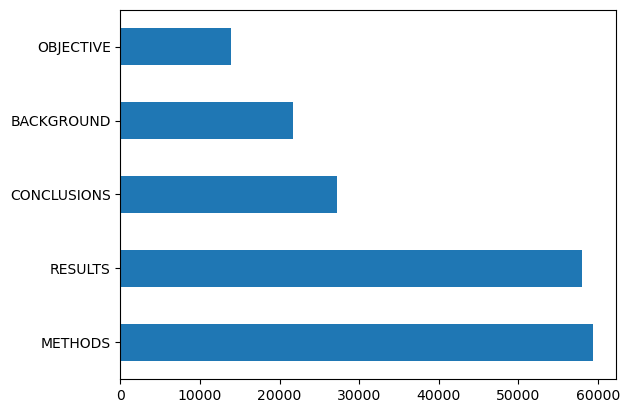

In [15]:
# sakinio etikečių pasiskirtymas train rinkinyje
train_df['target'].value_counts().plot.barh();

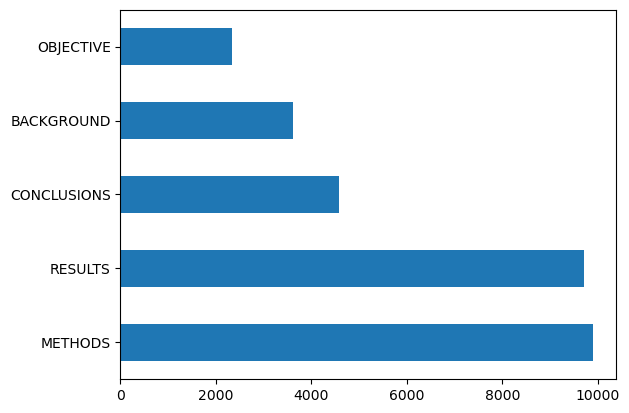

In [16]:
# sakinio etikečių pasiskirtymas test rinkinyje
test_df['target'].value_counts().plot.barh();

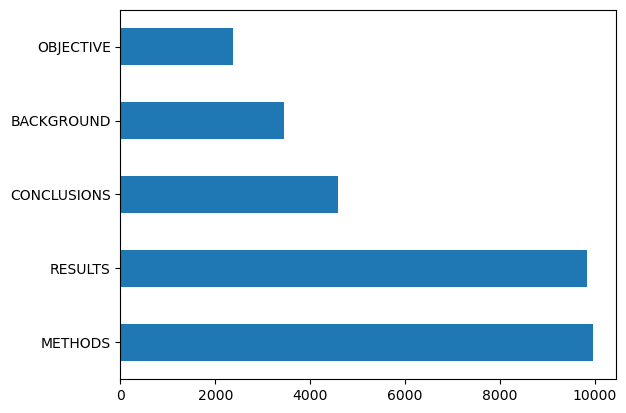

In [17]:
# sakinio etikečių pasiskirtymas val rinkinyje
val_df['target'].value_counts().plot.barh();

---

## Modelis 0: Bazinis modelis

**Bazinis modelis** - atskaitos taškas, su kuriuo lyginsime kitus modelius. Šis modelis mums padės įvertinti ar apsibrėžtai užduočiai reikia sudėtingesnio ANN modelio.

Remiantis [scikit-learn modelio parinkimo žemėlapiu](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) bazinių modelių buvo pasirinktas [daugianaris Naive Bayes klasifikatorius](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB), kuris apskaičiuos žodžio ar termino pasikartojimo konkrečios etiketės sakinyje tikimybę.

Kadangi klasifikuojame tekstą, jį reikia paversti skaitinėmis reikšmėmis. Tekstą transformuosime su [scikit-learn](https://scikit-learn.org) teksto savybių išskyrimo funkcija [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#), kuri retesniems terminams suteikia daugiau svarbos.

### Duomenų paruošimas

Baziniam modeliui naudosime santraukų sakinių tekstą (*text*) ir jų etikėtes kaip klasifikavimo klasės reikšmes (*target*).

In [18]:
# išskyriam santraukų sakinių tekstą
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()

In [19]:
# išvedam pirmus penkis X_train sąrašo elementus
X_train[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

Mašininio mokymo modeliai tai pat reikalauja skaičiais išreikštų rezultato reikšmių, todėl sakinių etiketes konvertuosime į skaičius:
- su [scikit-learn](https://scikit-learn.org) funkcija [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
- su [scikit-learn](https://scikit-learn.org) funkcija [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [21]:
# konvertuojam etikečių reikšmes į skaičius su LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["target"])
y_test = label_encoder.transform(test_df["target"])   
y_val = label_encoder.transform(val_df["target"])

In [22]:
# išedam pirmas 5 LabelEncoder užkuoduotas train etiketes
y_train[:5]

array([3, 2, 2, 2, 2])

In [23]:
# išsaugom etikėčių reikšmes
etiketes = label_encoder.classes_
etiketes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [24]:
# konvertuojam etikečių reikšmes į skaičius su OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

y_train_onehot = onehot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))   
y_val_onehot = onehot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))

In [25]:
# išedam pirmas 5 OneHotEncoder užkuoduotas train etiketes
y_train_onehot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Modelio kūrimas

Prieš perduodant duomenys į modelį juos reikia transformuoti, todėl teksto transformatorių ir klasifikatorių apjungiam panaudojant [scikit-learn](https://scikit-learn.org) klasės [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) objektą, kuriame nurodom, kokia eilės tvarka atlikti veiksmus.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
# sukūriam bazinį modelį
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),  # teksto transformatorius
    ("clf", MultinomialNB())        # Naive Bayse dauginaris klasifikatorius
])

### Modelio mokymas

Bazinio modelio mokymui perduodame **train** rinkinio sakinių tekstą **X_train** ir skaičiais užkoduotas sakinių etikėtes **y_train**.

In [28]:
model_0.fit(X_train, y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Rezultatai

Klasifikacijos problemos sprendimas dažniausiai vertinamos pagal šiuos parametrus:
- **accuracy** - tikslumas, rodantis kiek klasifikacija yra arti tikrosios vertės
- **precision** - kiek iš visų "*true*" identifikuotų reikšmių ištikro yra "*true*"
- **recall** - kiek visų rinkinyje esančiu "*true*" reikšmių įdentifikuota teisingai
- **F1 score** - sunjungia *precision* ir *recall* į vieną vertę

In [29]:
accuracy = model_0.score(X_test, y_test)

In [30]:
# precision, recall ir F1 score įverčių skaičiavimui naudosime scikit-learn funkciją
from sklearn.metrics import precision_recall_fscore_support

model_0_pred = model_0.predict(X_test)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, model_0_pred, average="weighted")


In [31]:
print("Bazinio modelio rezultatai:")
print(f"\taccuracy: \t{(accuracy * 100):.2f}%")
print(f"\tprecision: \t{(precision * 100):.2f}%")
print(f"\trecall: \t{(recall * 100):.2f}%")
print(f"\tF1 score: \t{(fscore * 100):.2f}%")

Bazinio modelio rezultatai:
	accuracy: 	71.67%
	precision: 	71.24%
	recall: 	71.67%
	F1 score: 	69.25%


><br>
>Pagal gautus rezultatus matome, kad mūsų bazinis modelis <b>~71% tikslumu</b> pritaiko teisingą sakinio etikėtę.<br>
><br>
>Reikia nepamiršti, kad bazinis modelis nekreipia dėmesio į sakinio vietą santraukoje, o klasifikuoja pagal dažniausiai pasitaikančius žodžius ar terminus.<br>
><br>

Sudarę sprendimų/sumaišties matricą (***Confusion Matrix***) pamatysime kiek kartų kiekviena etikėtė buvo identifikuota teisingai ir kiek kartų supainioto su kitomis.

Confusion matrica sudarysime su [scikit-learn](https://scikit-learn.org) funkcija [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), atvaizduosime su klasės [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) objektu. 

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, display_labels):
    """
    Grąžina Confusion matricos diagramą

    Args:
        y_true: teisingos reikšmės
        y_pred: modelio spėtos reikšmės
        display_labels: klasių pavadinimai
    """   

    cm = confusion_matrix(y_true, y_pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_plot.plot(xticks_rotation="vertical", cmap="Blues", colorbar=False);

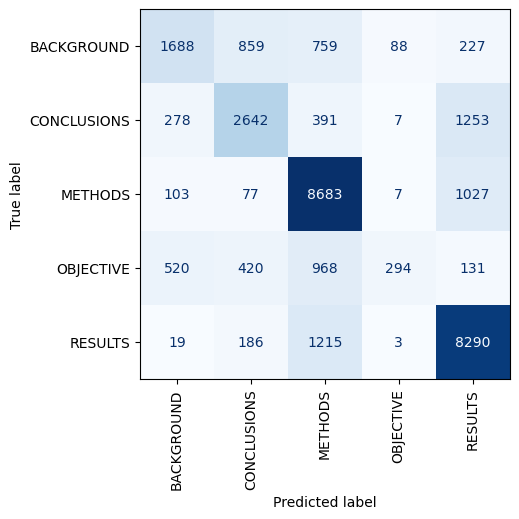

In [33]:
plot_confusion_matrix(y_test, model_0_pred, etiketes)

In [34]:
precisions, recalls, fscores, _ = precision_recall_fscore_support(y_test, model_0_pred)

In [35]:
# išvedam kiekvienos etikėtes klasifikavimo rezultatą
print(f"{'Label':12} | Precision | Recall | F1 score |")
print("-"*46)
for i, label in enumerate(etiketes):
    print(f"{label:12} | {(precisions[i]*100):9.2f} | {(recalls[i]*100):6.2f} | {(fscores[i]*100):8.2f} |")

Label        | Precision | Recall | F1 score |
----------------------------------------------
BACKGROUND   |     64.72 |  46.62 |    54.20 |
CONCLUSIONS  |     63.15 |  57.80 |    60.35 |
METHODS      |     72.26 |  87.73 |    79.25 |
OBJECTIVE    |     73.68 |  12.60 |    21.52 |
RESULTS      |     75.86 |  85.35 |    80.33 |


><br>
>Baziniam modeliui sunkiausiai sekasi identifikuoti OBJECTIVE etiketę, kuri dažniausiai identifikuojama kaip METHODS arba BACKGROUND.<br>
><br>
>Geriausiai sekasi identifikuoti RESULTS ir METHODS etiketes, kurios tarpusavyje dažniausiai ir maišomos.<br>
><br>
>Šį rezultatą lemia etikėte pažymėtų sakinių skaičius duomenų rinkinyje, t.y. žodžiai/terminai dažniausiai pasikartos tos etiketės sakiniuose, kurios sakinių daugiausia.<br>
><br>

---

## Modelis 1: Conv1D with token embedding

TensorFlow ANN modelį sudaris šie sluoksniai:
1. **Input** - įvedimo sluoksnis, kuriam perduodamas santraukos sakinio tekstas ir etiketė
2. **TextVectorizer** - sužymi sakinio žodžius sveikais skaičiais, pagal iš anksto sudarytą žodžių (*token*) žodyną
3. **Embedding** - paverčia kiekvieną sveiku skaičiumi pažymėtą sakinio žodį nurodyto fiksuoto dydžio vekoriumi
4. **Conv1D** - atlieka vienmatę konvoliuciją pagal nurodyto dydžio langą (*kernel*)
5. **GlobalAveragePooling1D** - sutankina Conv1D rezultata, grąžindamas vidurkių vektorių
6. **Dense** - išvedimo sluoknis, grąžina kiekvienos etikėtės tikimybę

 ### Duomenų paruošimas

**Tokenization** yra žodžių, skaičių simbolių ir (arba) skyrybos ženklų pavertimas sveikais skaičiais. Šio proceso metu yra sudaromas nurodyto dydžio žodynas, kuriame žodis (*token*) susiejamas su skaičiumi, žodžiai rikiuojami mažėjimo tvarka nuo dažniausiai pasikartojančio.

**Embedding** proceso metu sveiki token'ų skaičiai paverčiami fiksuoto dydžio vektoriais.

Santraukų sakinių vektorizacija atliksime su [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) sluoksniu, kuriam nurodysime pageidaujamo tokenizacijos žodyno dydį bei vektorizuoto santraukos sakinio ilgį. Todėl pirmiausia turime išsiaiškinti kokio vdutiniškai ilgio yra santraukų sakiniai bei kiek skirtingų žodžių yra naudojamo rinkinio santraukose.

In [36]:
# randam santraukų sakinių ilgių vidurkį bei ilgiausio sakinio ilgį X_train rinkinyje
sentence_lens = [len(sentence.split()) for sentence in X_train] # sudarom sakinių ilgių sąrašą
avg_sentence_len = int(np.mean(sentence_lens)) # vidutinis žodžių skaičius sakinyje
max_sentence_len = np.max(sentence_lens) # ilgiausio sakinio žodžių skaičius

print(f"Sakinių ilgių vidurkis: {avg_sentence_len} žodžiai")
print(f"Ilgiausias sakinys: {max_sentence_len} žodžiai")

Sakinių ilgių vidurkis: 26 žodžiai
Ilgiausias sakinys: 296 žodžiai


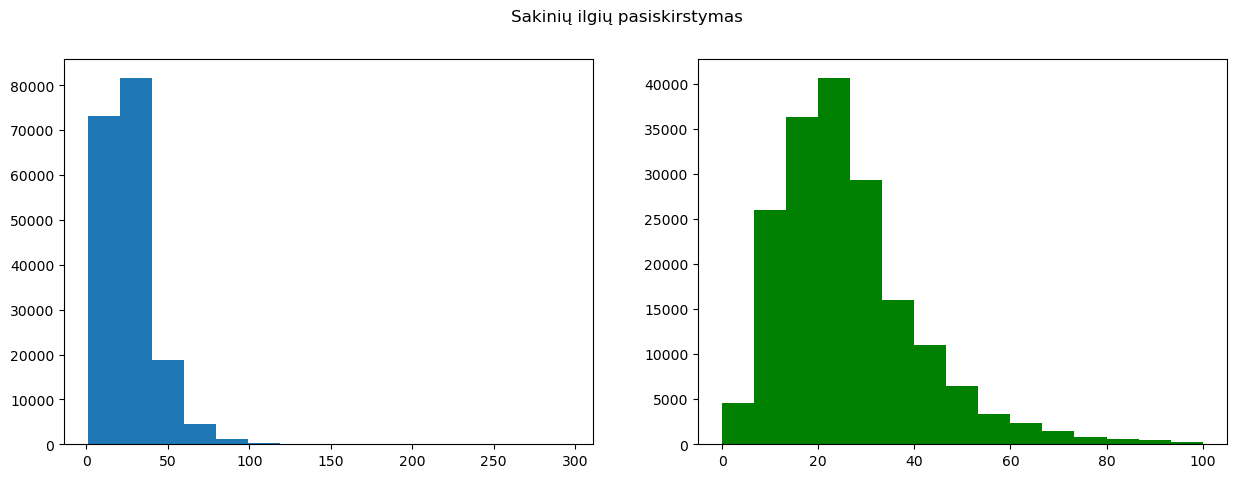

In [37]:
# atvaizduojam sakinių ilgių pasiskirstymą su histograma
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Sakinių ilgių pasiskirstymas")

ax[0].hist(sentence_lens, bins=15)
ax[1].hist(sentence_lens, bins=15, range=[0, 100], facecolor='green', align='mid')

plt.show()

In [38]:
# randam kokio maksimalaus ilgio yra 95% visų sakinių
output_sentence_len = int(np.percentile(sentence_lens, 95))
print(f"Maksimalus sakinių ilgis tarp 95% visų sakinių: {output_sentence_len} žodžiai")

Maksimalus sakinių ilgis tarp 95% visų sakinių: 55 žodžiai


#### Sakinių teksto vektorizacija su žodžių tokenizacija

Atlikti santraukų sakinių teksto vektorizacijai papildomai reikia visų skirtingų žodžių skaičiaus, šis skaičius nurodytas duomenų rinkinio [**PubMed 200k RCT**](https://arxiv.org/pdf/1710.06071.pdf) aprašymo antroje lentelėje.

Rinkinio **PubMed_20k_RCT** žodyną sudaro **68 tūkst.** žodžių.

In [ ]:
# nurodom maksimalu duomenų rinkinio žodyno dydį
max_tokens = 68000

# sukuriam vektorizavimo sluoksnį
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                           output_sequence_length=output_sentence_len)

# sukuriam tokenizacijos žodyną naudojant X_train sakinius
text_vectorizer.adapt(X_train)

In [40]:
# patikrinam teksto sakinių vektorizaciją su pasirinktu sakiniu
test_sentence = X_train[2]

print(f"Originalus sakinio tekstas:\n{test_sentence}\n")
print(f"Vektorizuotas sakinio tekstas:\n{text_vectorizer([test_sentence])}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Vektorizuotas sakinio tekstas:
[[ 86 213 121  65 169   3 194   5 149 119   3 670 636 747   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [41]:
# tokenizacijos metu sudaryto žodyno apžvalga
tokens_vocabulary = text_vectorizer.get_vocabulary()

print(f"Žodžių skaičius žodyne: {len(tokens_vocabulary)}")
print(f"Dažniausi žodžiai: {tokens_vocabulary[:10]}")
print(f"Rečiausi žodžiai: {tokens_vocabulary[-10:]}")

Žodžių skaičius žodyne: 64841
Dažniausi žodžiai: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Rečiausi žodžiai: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Tokenizuotų žodžių embedding'as

In [42]:
# sukuriam žodžių embedding'o sluoksnį
token_embedder = layers.Embedding(input_dim=len(tokens_vocabulary),
                                  output_dim=128, # rezultato vektoriaus dydis
                                  mask_zero=True, # paslepiam vektorizuoto sakinio tuščias reikšmes
                                  name="token_embedding")

In [43]:
# patikrinam sakinio teksto vektorizaciją kartu su token'ų embedding'u
original_sentence = X_train[2]
print(f"Originalus sakinio tekstas:\n{original_sentence}")

vectorized_sentence = text_vectorizer([original_sentence])
print(f"\nVektorizuotas sakinio tekstas:\n{vectorized_sentence}")

embedded_sentence = token_embedder(vectorized_sentence)
print(f"\nVektorizuotas sakinio tekstas su embedding'u:\n{embedded_sentence}")

print(f"\nVektorizuoto sakinio formatas: {vectorized_sentence.shape}")
print(f"Embedded sakinio formatas: {embedded_sentence.shape}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Vektorizuotas sakinio tekstas:
[[ 86 213 121  65 169   3 194   5 149 119   3 670 636 747   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Vektorizuotas sakinio tekstas su embedding'u:
[[[-0.00414361  0.03393172 -0.03564606 ...  0.01597646 -0.04474573
   -0.00083514]
  [ 0.0386476  -0.04212198 -0.04941039 ...  0.00176691 -0.04607695
    0.01558188]
  [ 0.03308741  0.0497742   0.01614207 ...  0.03469983 -0.03435211
   -0.03121449]
  ...
  [ 0.03867353 -0.00454335  0.02694147 ... -0.04205865 -0.01979903
   -0.03919976]
  [ 0.03867353 -0.00454335  0.02694147 ... -0.04205865 -0.01979903
   -0.03919976]
  [ 0.03867353 -0.00454335  0.02694147 ... -0.04205865 -0.01979903
   -0.03919976]]]

Vektorizuoto sakinio formatas: (1, 55)
Embed

#### TensorFlow Dataset sudarymas

**GPU** ir **TPU** gali drastiškai sutrumpinti laiką, reikalingą vienam mokymo žingsniui atlikti. [tf.data](https://www.tensorflow.org/guide/data) API padeda sukurti efektyvias duomenų struktūras, kuriomis duomenys kitam veiksmui perduodami dar nepasibaigus dabartiniam.

Santraukų sakinius ir *One Hot* koduotas etiketes sujungiam su **TesorFlow Dataset** metodu [from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices). Sudarytus *Dataset* rinkinius suskirstom į **paketus po 32** pavyzdžius naudojant [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), papildmai su [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) nurodysim paruošti vėlesnius duomenis, kol apdorojamas dabartinis.

In [44]:
# turimus duomenis perkėliam į TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_onehot))

In [45]:
# suskirstom duomenis į paketus po 32 pavyzdžius
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
# patikrinam sudarytus duomenų rinkinius
train_dataset, test_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Modelio sudarymas

In [47]:
# įvedimo sluoksnis
inputs = layers.Input(shape=(1,), dtype=tf.string)

# duomenų apdorojimo sluoksniai
text_vectors = text_vectorizer(inputs) # vektorizuojam įvedimą
token_embeddings = token_embedder(text_vectors) # embeddinam vektorizuotus sakinius

# atliekam 64 filtrų vienmatę konvoliuciją naudojant 5 reikšmių branduolį (langą) ir sutankinam rezultatus
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)

 # išvedimo sluoksnis
outputs = layers.Dense(units=len(etiketes), activation="softmax")(x)

# aprašom modelį, nurodydami įvedimo ir išvedimo sluoksnius
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [48]:
# sukūriam (kompiliuojam) aprašytą modelį
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# išvedam sudaryto modelio struktūra
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325 

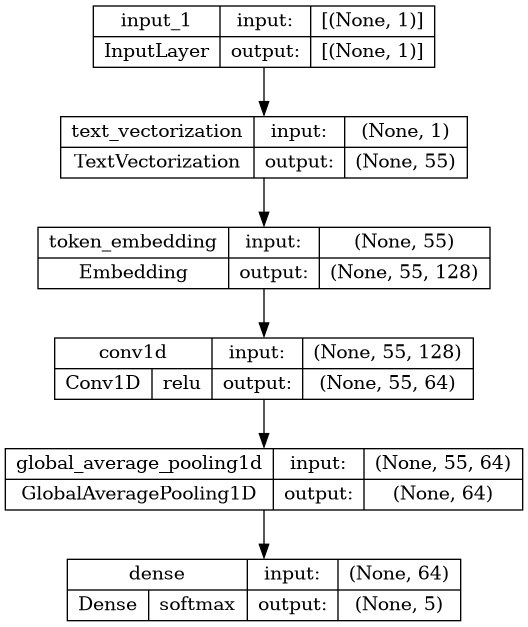

In [50]:
# modelio diagramos sudarymas
from keras.utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_activations=True, to_file="model-img/m1.png")

### Modelio mokymas

Modelio mokyma atliksime su paruoštu *TensorFlow Dataset* duomenų rinkinių **train_dataset**, vienai epochai skirdami 10% duomenų rinkinio pavyzdžių. Įvertinimą atliksime su 10% **val_dataset** pavyzdžių.

Mokysim **5 epochas**, t.y. modelis 5 kartus pamatys nurodytą kiekį mokymo pavyzdžių. Jei nenurodytas parametras *steps_per_epoch* modelis per vieną epochą pamato visus mokymo pavyzdžius.

>Nurodyti mokymo parametrai pasirinkti norint kiek imanoma sutrumpinit mokymo procesą.

In [51]:
# atliekam modelio mokymą naudojant tik 10% duomenų paketų (batches)
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)),
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir="tensorboard")])

Epoch 1/5


2023-03-17 13:58:18.841309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-17 13:58:19.419710: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd424021920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-17 13:58:19.419734: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-17 13:58:19.424246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-17 13:58:19.554666: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 28s 45ms/step - loss: 0.9142 - accuracy: 0.6367 - val_loss: 0.6872 - val_accuracy: 0.7384
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6608 - accuracy: 0.7531 - val_loss: 0.6348 - val_accuracy: 0.7673
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6212 - accuracy: 0.7727 - val_loss: 0.5994 - val_accuracy: 0.7849
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5905 - accuracy: 0.7880 - val_loss: 0.5789 - val_accuracy: 0.7882
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5914 - accuracy: 0.7927 - val_loss: 0.5627 - val_accuracy: 0.7969


### Modelio vertinimas

**TensorFlow** modelius vertinsim šiais etapais:
1. Mokymo (*training*) ir įvetinimo (*validation*) etapų tisklumų (*accuracy*) ir praradimų (*loss*) kreivių palyginimas
2. Modelio tikslumo įvertinimas su testavimo (*test_dataset*) duomenimis
3. Klasifikacijos įvertinimas su testavimo (*test_dataset*) duomenimis (*precision, recall, F1 Score*)

Prieš atliekant "Modelis 1" vertinimą paruošime pagalbines funkcijas, kurias naudosim vertinant kitus modelius:
- **plot_accuracy_loss_curves** - mokymo ir įvertinimo etapų praradimų (*loss*) bei tikslumų (*accuracy*) kreivių palyginimo diagramų sudarymas
- **print_classification_results** - klasifikacijos įverčių spausdinimas

In [52]:
def plot_accuracy_loss_curves(history, model_name):
    """
    Grąžina mokymo ir įvertinimo praradimo (loss) ir tikslumo kreivių palyginimą

    Args:
        history: TensorFlow modelio History objektas, gaunamas mokinant modelį
        model_name: modelio pavadinimas
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(history.history['loss'])+1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Modelio {model_name} mokymosi ir įvertinimo rezultatai")

    # tikslumo (accuracy) palyginimas
    ax[0].plot(epochs, train_accuracy)
    ax[0].plot(epochs, val_accuracy)
    ax[0].legend(['mokymasis', 'įvertinimas'], loc='upper left')
    ax[0].set_title("Tikslumų (accuracy) palyginimas")
    ax[0].set_xlabel("Epochos")
    ax[0].set_ylabel("Tikslumas")
    
    # praradimų (loss) palyginimas
    ax[1].plot(epochs, train_loss, label='training_loss')
    ax[1].plot(epochs, val_loss, label='val_loss')
    ax[1].legend(['mokymasis', 'įvertinima'], loc='upper right')
    ax[1].set_title("Praradimų (loss) palyginimas")
    ax[1].set_xlabel("Epochos")
    ax[1].set_ylabel("Praradimas")

    plt.show()

In [53]:
from sklearn.metrics import precision_recall_fscore_support

def print_classification_results(y_true, y_pred, model_name):
    """
    Spausdina klasifikacijos įverčius precision, recall, F1 score

    Args:
        y_true: teisingos reikšmės
        y_pred: modelio spėtos reikšmės
        model_name: modelio pavadinimas
    """

    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true, y_pred)
    accuracy_result = float(accuracy.result().numpy())
    
    precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Modelio {model_name} klasifikacijos rezultatai:")
    print(f"\tAccuracy: {(accuracy_result*100):.2f}%")
    print(f"\tPrecision: {(precision*100):.2f}%")
    print(f"\tRecall: {(recall*100):.2f}%")
    print(f"\tF1 score: {(f1score*100):.2f}%")

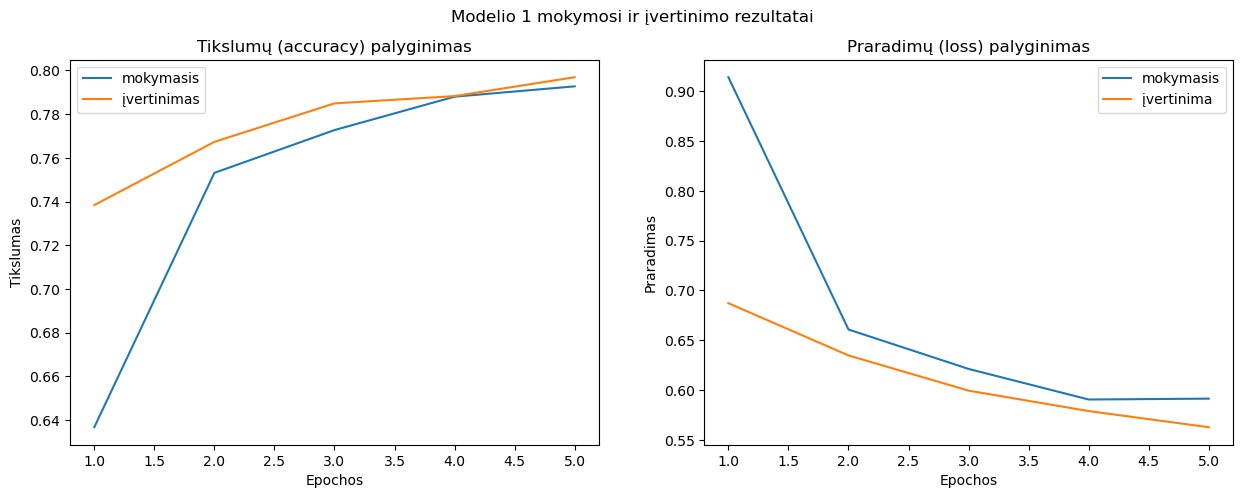

In [54]:
# sudarom modelio "Modelis 1" vertinimo diagramas
plot_accuracy_loss_curves(model_1_history, "1")

**Tikslumų (*accuracy*) kreivės** parodo kaip modelis po kiekvienos mokymosi epochos klasifikuoja pateiktus pavyzdžius.

**Praradimų (*loss*) kreivės** rodo kaip modelis mokosi iš pateiktų duomenų:
- **mokymosi** - kaip mokomasi iš mokymosi pavyzdžių (*train_dataset*)
- **įvertinimo** - kaip mokomasi iš mokymosi metu nematytų pavyzdžių (*val_dataset*)

Jei mokymosi *loss* kreivė kyla į viršų, galime įžvelgti modelio nesimokinimą (**underfitting**), jei įvertinimo *loss* kreivė kyla į viršų, galime įžvelgti persimokinimą (**overfitting**).



In [55]:
# įvertinam modelį su visais testavimo rinkinio pavyzdžiais
loss, accuracy = model_1.evaluate(test_dataset)
print(f"Modelio 1 tikslumas su testavimo duomenimis: {(accuracy*100):.2f}%")

942/942 [==============================] - 3s 3ms/step - loss: 0.5757 - accuracy: 0.7934
Modelio 1 tikslumas su testavimo duomenimis: 79.34%


><br>
><b>Modelis 1</b> klasifikuoja santraukų sakinius ~79% tikslumu, po 4 mokymo epochų nustoja mokintis iš pateiktų pavyzdžių. <br>
><br>

### Palyginimas su baziniu modeliu

Atliekant daugiaklasę klasifikaciją, modelis naudojant [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) aktyvavimo funkciją grąžina kiekvienos etiketės tikimybę. Mus domina didžiausios tikimybės indeksas, tai bus klasės indeksas etikečių sąraše, gautame etikėtes užkodavus su [scikit-learn LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [56]:
# paruošiam Modelis 1 rezultatus klasifikacijos rezultatų spausdinimui
model_1_pred_probabilities = model_1.predict(test_dataset) # gaunam modelio tikimybes kiekvienai etiketei
model_1_pred = tf.argmax(model_1_pred_probabilities, axis=1) # randam didžiausios tikimybės indeksą

942/942 [==============================] - 2s 2ms/step


In [57]:
# spausdinam klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_1_pred, model_name="1")

Modelio 1 klasifikacijos rezultatai:
	Accuracy: 79.34%
	Precision: 79.31%
	Recall: 79.34%
	F1 score: 79.00%


In [58]:
# spausdinam bazinio modelio klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_0_pred, model_name="Bazinis")

Modelio Bazinis klasifikacijos rezultatai:
	Accuracy: 71.67%
	Precision: 71.24%
	Recall: 71.67%
	F1 score: 69.25%


><br>
>Modelio 1 klasifikacijos rezultatai, lyginant su Baziniu modeliu, pagerėjo ~8%. Didžiausias pokytis F1 score įverčio ~10%, kuris rodo, kad modelis pradėjo šiek tiek geriau skirti dažniausiai tarpusavyje maišytas santraukos sakinių etikėtes.<br>
><br>

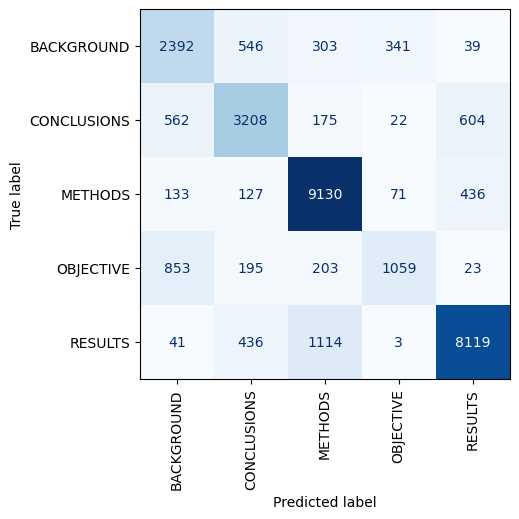

In [59]:
# Modelis 1 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_1_pred, display_labels=etiketes)

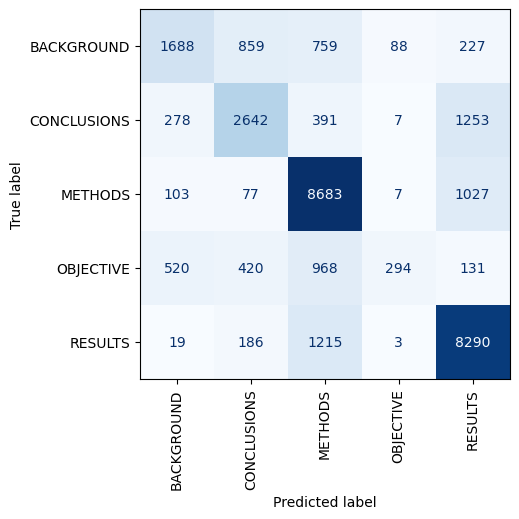

In [60]:
# Modelis 0 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_0_pred, display_labels=etiketes)

><br>
>Pagal spėjimų (<i>confusion</i>) matricas <b>Modelis 1</b> teisingiau parenka <b>BACKGROUND</b>, <b>CONCLUSIONS</b> ir <b>METHODS</b>, žymiai tiksliau pradėjo klasifikuoti sakinius su <b>OBJECTIVE</b> etikėte. Tačiau etikėtę <b>RESULTS</b> pradėjo dažniau maišyti su <b>CONCLUSIONS</b><br>
><br>

---

## Modelis 2: Feature extraction with pretrained token embeddings

Antrą TensorFlow modelį sudarysime panaudoje kitą iš anksto paruoštą modelį kaip mūsų užduoties pradžios tašką. Toks ANN sudarymo metodas vadinamas **mokymosi perkėlimų** (*transfer learning*).

Modelis 2 bus sudarytas Modelis 1 pagrindu, tačiau pakeičiant santraukų sakinių teksto vektorizacijos sluoksnius kitais paruoštais iš anksto - atliksim savybių išskyrimą (*feature extraction*).

Dokumente [**Neural Networks for Joint Sentence Classification in Medical Paper Abstracts**](https://arxiv.org/pdf/1612.05251), kuriuo remiantis atliekama užduotis, šiam tiklsui buvo naudojamas [GloVe](https://nlp.stanford.edu/projects/glove/) embedding'as. Mūsų atveju bus naudojamas panašus, bet naujesnis modelis, kuri galim rasti [TensorFlow Hub](https://www.tensorflow.org/hub) repozitorijoje, tai [Universal Sentence Encoder (v4)](https://tfhub.dev/google/universal-sentence-encoder/4).

### Universal Sentence Encoder paruošimas modeliui

In [61]:
# importuojam TensorFlow Hub modulį
import tensorflow_hub as hub

# atsisiunčiam if TF Hub Universal Sentence Encoder
use_embedder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", # nuoroda į iš anksto apmokyta modelį
                                    trainable=False, # nurodome nekeisti modelio išmoktų savybių
                                    name="universal_sentence_encoder")

In [62]:
# testuojam atsisiųstą Universal Sentence Extractor
original_sentence = X_train[2]
print(f"Originalus sakinio tekstas:\n{original_sentence}")

use_embedded_sentence = use_embedder_layer([original_sentence])
print(f"\nEmbedded sakinio tekstas:\n{use_embedded_sentence}")
print(f"\nEmbedded sakinio formatas: {use_embedded_sentence.shape}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Embedded sakinio tekstas:
[[-0.03213719 -0.05753418  0.01531489 -0.05842334 -0.01752247  0.04761694
  -0.06377345  0.01332154  0.00713375  0.07151651  0.06588907 -0.07033636
  -0.02220715  0.00944613 -0.00226985 -0.02005818 -0.05543549  0.04410325
  -0.03673979 -0.01640125  0.04783256  0.08097818 -0.02554446  0.02655392
   0.04831062 -0.04355301  0.06009774  0.02457012  0.03512819  0.0232308
  -0.02681095  0.06625807  0.06900754 -0.02099541 -0.0474609   0.04555487
  -0.00018019 -0.00470593  0.06078606 -0.04961505 -0.07365107  0.03713046
   0.04230668 -0.04472004 -0.00967144 -0.06212262 -0.05969518 -0.02956358
   0.04998933  0.01824023 -0.03833311  0.00759324 -0.04730164 -0.02012259
   0.02840563  0.01506106  0.00490208  0.03297986  0.02609313  0.0170767
  -0.02390434  0.0428432   0.0488422   0.04468543  0.03245289 -0.02413252
   0.07125775 -0.0420

### Modelio sudarymas

In [63]:
# įvedimo sluoksnis
inputs = layers.Input(shape=[], dtype=tf.string)

# duomenų apdorojimo sluoksniai
pretrained_use_layer = use_embedder_layer(inputs)   # vektorizuojam įvedimą su Universal Sentence Encoder
x = layers.Dense(units=128, activation="relu")(pretrained_use_layer) 

# išvedimo sluoksnis
outputs = layers.Dense(units=5, activation="softmax")(x)

# aprašom modelį, nurodydami įvedimo ir išvedimo sluoksnius
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

In [64]:
# sukūriam (kompiliuojam) aprašytą modelį
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# išvedam sudaryto modelio struktūra
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


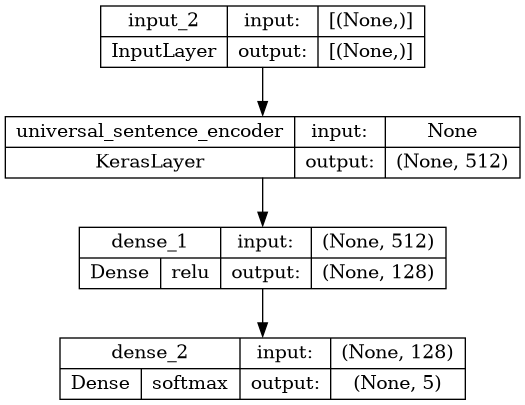

In [66]:
# modelio diagramos sudarymas
from keras.utils import plot_model
plot_model(model_2, show_shapes=True, show_layer_activations=True, to_file="model-img/m2.png")

### Modelio mokymas

In [67]:
# atliekam modelio mokymą naudojant tik 10% duomenų paketų (batches)
model_2_history = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)),
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir="tensorboard")])

Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9145 - accuracy: 0.6509 - val_loss: 0.7946 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7677 - accuracy: 0.7013 - val_loss: 0.7510 - val_accuracy: 0.7055
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7489 - accuracy: 0.7137 - val_loss: 0.7337 - val_accuracy: 0.7191
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7161 - accuracy: 0.7250 - val_loss: 0.7057 - val_accuracy: 0.7320
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.7241 - accuracy: 0.7210 - val_loss: 0.6870 - val_accuracy: 0.7337


### Modelio vertinimas

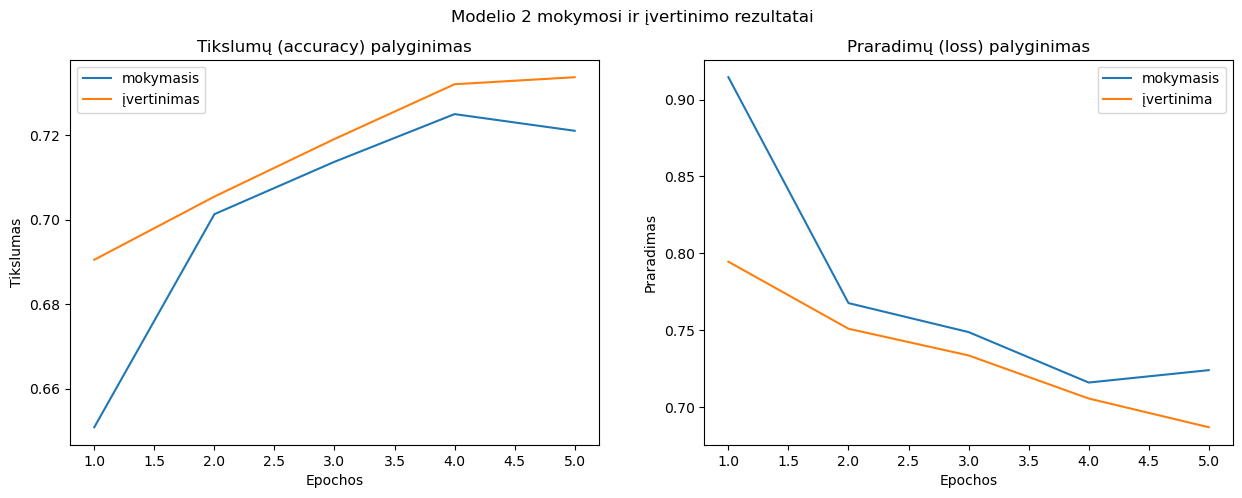

In [68]:
# sudarom modelio "Modelis 2" vertinimo diagramas
plot_accuracy_loss_curves(model_2_history, "2")

In [69]:
# įvertinam modelį su visais testavimo rinkinio pavyzdžiais
loss, accuracy = model_2.evaluate(test_dataset)
print(f"Modelio 2 tikslumas su testavimo duomenimis: {(accuracy*100):.2f}%")

942/942 [==============================] - 8s 9ms/step - loss: 0.7138 - accuracy: 0.7268
Modelio 2 tikslumas su testavimo duomenimis: 72.68%


><br>
><b>Modelis 2</b> klasifikuoja santraukų sakinius ~72% tikslumu, po 4 mokymo epochų nustoja mokintis iš pateiktų pavyzdžių. <br>
><br>

### Modelio palyginimas su baziniu modeliu

In [70]:
# paruošiam Modelis 2 rezultatus klasifikacijos rezultatų spausdinimui
model_2_pred_probabilities = model_2.predict(test_dataset) # gaunam modelio tikimybes kiekvienai etiketei
model_2_pred = tf.argmax(model_2_pred_probabilities, axis=1) # randam didžiausios tikimybės indeksą

942/942 [==============================] - 8s 8ms/step


In [71]:
# spausdinam klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_2_pred, model_name="2")

Modelio 2 klasifikacijos rezultatai:
	Accuracy: 72.68%
	Precision: 72.21%
	Recall: 72.68%
	F1 score: 72.11%


In [72]:
# spausdinam bazinio modelio klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_0_pred, model_name="Bazinis")

Modelio Bazinis klasifikacijos rezultatai:
	Accuracy: 71.67%
	Precision: 71.24%
	Recall: 71.67%
	F1 score: 69.25%


><br>
>Modelio 2 klasifikacijos rezultatai, lyginant su Baziniu modeliu, pagerėjo tik ~1%. Pokytis F1 score įverčio ~3%, kai modelio 1 atveju buvo ~10% didesnis.<br>
><br>

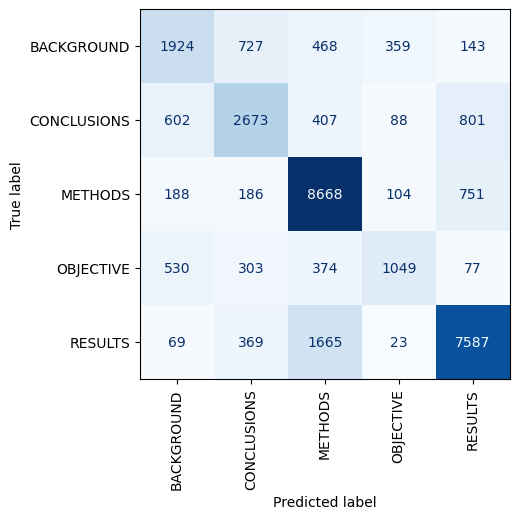

In [73]:
# Modelis 2 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_2_pred, display_labels=etiketes)

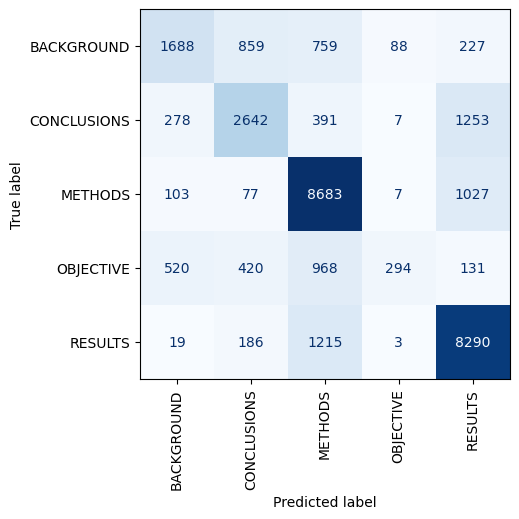

In [74]:
# Modelis 0 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_0_pred, display_labels=etiketes)

><br>
>Pagal spėjimų (<i>confusion</i>) matricas <b>Modelis 2</b> pradėjo klaidingiau klasifikuoti <b>RESULTS</b> etikėtę, šiek tiek geriau <b>BACKGROUND</b>. Teisingai suklasifikuotų kitų etikečių skaičius pasikeitė nežymiai.<br>
><br>

---

## Modelis 3: Conv1D with character embeding

Iki šio momento geriausius rezultatus pateikė Modelis 1, kuriame naudojome santraukų sakinių vektorizaciją su teksto ***žodžių embedding'u***. **Modelyje 3** įgyvendinsim Modelį 1, tik sakinius vektorizuosim ne žodžių, o simbolių lygmenyje, t.y. atliksime ***simbolių embedding'ą***.

### Duomenų paruošimas

Santraukų sakinių vektorizacija atliksime su jau matytu [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) sluoksniu, kuriam reikia nurodyti pageidaujamo tokenizacijos žodyno dydį bei vektorizuoto santraukos sakinio ilgį. Todėl pirmiausia turime išsiaiškinti koks skaičius simbolių vdutiniškai sudaro sakinį bei kiek skirtingų simbolių yra naudojamą.

In [75]:
# sukuriam funkciją atskirančią sakinio teksto simbolius
def split_sentence_chars(text):
    """
    Grąžina sakinio tekstą su tarpu atskirtais skimboliais

    Args:
        text: skaidomo sakinio tekstas    
    """
    return " ".join(list(text))

In [76]:
# patikrinam simbolių skaidymo funkcija
original_sentence = X_train[2]
print(f"Originalus sakinio tekstas:\n{original_sentence}")

split_sentence = split_sentence_chars(original_sentence)
print(f"\nĮ simbolius suskaidytas tekstas:\n{split_sentence}")

Originalus sakinio tekstas:
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

Į simbolius suskaidytas tekstas:
O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .


In [77]:
# sudarom duomenų rinkinius su santraukų sakinių išskaidymų į simbolius
X_train_chars = [split_sentence_chars(sentence) for sentence in X_train]
X_test_chars = [split_sentence_chars(sentence) for sentence in X_test]
X_val_chars = [split_sentence_chars(sentence) for sentence in X_val]

In [78]:
# išvedam pirmus 5 simboliais suskaidyto duomenų rinkinio train.txt sakinius
X_train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [79]:
# randam kiek simbolių vidutiniškai sudaro santraukos sakinį bei koks ilgiausio sakinio simbolių skaičius
sentence_chars_lens = [len(sentence) for sentence in X_train] # sudarom sakinių ilgių sąrašą
avg_sentence_chars_len = int(np.mean(sentence_chars_lens)) # vidutinis žodžių skaičius sakinyje
max_sentence_chars_len = np.max(sentence_chars_lens) # ilgiausio sakinio žodžių skaičius

print(f"Vidutinis sakinį sudarančių simbolių skaičius: {avg_sentence_chars_len} simboliai")
print(f"Ilgiausią sakinį sudaro: {max_sentence_chars_len} simboliai")

Vidutinis sakinį sudarančių simbolių skaičius: 149 simboliai
Ilgiausią sakinį sudaro: 1386 simboliai


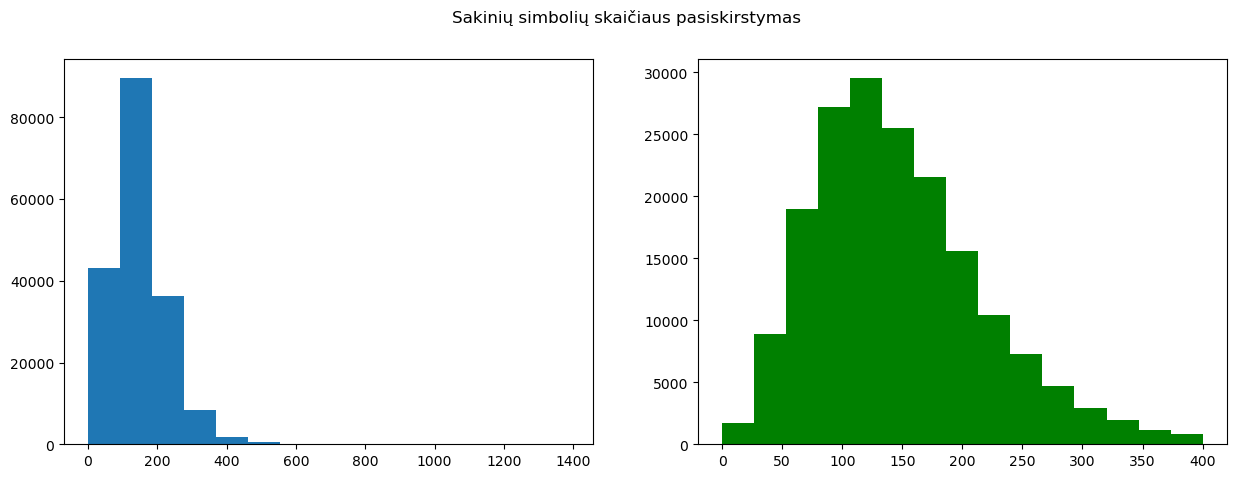

In [80]:
# atvaizduojam sakinių simbolių skaičiaus pasiskirstymą su histograma
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Sakinių simbolių skaičiaus pasiskirstymas")

ax[0].hist(sentence_chars_lens, bins=15)
ax[1].hist(sentence_chars_lens, bins=15, range=[0, 400], facecolor='green', align='mid')

plt.show()

In [81]:
# randam koks maksimalus sakinio simbolių skaičius tarp 95% visų sakinių
output_sentence_chars_len = int(np.percentile(sentence_chars_lens, 95))
print(f"Maksimalus sakininio simbolių skaičius tarp 95% visų sakinių: {output_sentence_chars_len} simbolių")

Maksimalus sakininio simbolių skaičius tarp 95% visų sakinių: 290 simbolių


### Sakinių vektorizacija su simbolių tokenizavimu

Skirtingų žodžių skaičius tokenizacijos žodynui sudaryti buvo nurodytas duomenų rinkinio [**PubMed 200k RCT**](https://arxiv.org/pdf/1710.06071.pdf) aprašymo antroje lentelėje. 

Maksimalių skirtingų simbolių žodyno skaičiumi nurodysim simbolių sudarytu iš **mažųjų ASCII raidžių**, **skaičių** bei **skyrybos ženklų** skaičių. Papildomai pridėsim 2 simbolius:
- tarpo simboliui
- OOV (*Out Of Vocabulary*) simboliui, token'ų žodyne jis žymymas *[UNK]*

In [82]:
# nurodom maksimalu duomenų rinkinio žodyno dydį
import string
max_char_tokens = len(string.ascii_lowercase + string.digits + string.punctuation) + 2

In [83]:
# sukuriam vektorizavimo sluoksnį
char_vectorizer = layers.TextVectorization(max_tokens=max_char_tokens,
                                           output_sequence_length=output_sentence_chars_len,
                                           name="char_vectorizer")

# sukuriam tokenizacijos žodyną naudojant į simbolius išskaidytus X_train_chars sakinius
char_vectorizer.adapt(X_train_chars)

In [84]:
# patikrinam simboliais išskyrstyto teksto sakinių vektorizaciją su pasirinktu sakiniu
test_sentence = X_train_chars[2]

print(f"Simboliais išskirstyto sakinio tekstas:\n{test_sentence}\n")
print(f"Vektorizuotas sakinio tekstas:\n{char_vectorizer([test_sentence])}")

Simboliais išskirstyto sakinio tekstas:
O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .

Vektorizuotas sakinio tekstas:
[[ 7 16  3 11  7 15  2 15  2  5  9 16  8  2  9  4  6 11 12 16 10  2 10 14
   5  4  6  8  2 10 16 11  3  4  7  6  5  6 10  4 15 14  8  7 21  2 15  2
   6  3  4  6 17 16  6 11  3  4  7  6  9 11  7  8  2  9  5  6 10  9 19  9
   3  2 15  4 11  4  6 17 12  5 15 15  5  3  4  7  6 15  5  8 23  2  8  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0

In [85]:
# tokenizacijos metu sudaryto žodyno apžvalga
char_tokens_vocabulary = char_vectorizer.get_vocabulary()

print(f"Simbolių skaičius žodyne: {len(char_tokens_vocabulary)}")
print(f"Dažniausi simboliai: {char_tokens_vocabulary[:10]}")
print(f"Rečiausi simboliai: {char_tokens_vocabulary[-10:]}")

Simbolių skaičius žodyne: 28
Dažniausi simboliai: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
Rečiausi simboliai: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


### Simbolių embedding'as

In [86]:
#  sukuriam simbolių embedding'o sluoksnį
char_token_embedder = layers.Embedding(input_dim=len(char_tokens_vocabulary),
                                       output_dim=28, # rezultato vektoriaus dydis
                                       mask_zero=True, # paslepiam vektorizuoto sakinio tuščias reikšmes
                                       name="char_token_embedding")

In [87]:
# patikrinam sakinio teksto vektorizaciją kartu su simbolių token'ų embedding'u
original_sentence = X_train_chars[2]
print(f"Originalus sakinio tekstas:\n{original_sentence}")

vectorized_sentence = char_vectorizer([original_sentence])
print(f"\nVektorizuotas sakinio tekstas:\n{vectorized_sentence}")

embedded_sentence = char_token_embedder(vectorized_sentence)
print(f"\nVektorizuotas sakinio tekstas su embedding'u:\n{embedded_sentence}")

print(f"\nVektorizuoto sakinio formatas: {vectorized_sentence.shape}")
print(f"Embedded sakinio formatas: {embedded_sentence.shape}")

Originalus sakinio tekstas:
O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .

Vektorizuotas sakinio tekstas:
[[ 7 16  3 11  7 15  2 15  2  5  9 16  8  2  9  4  6 11 12 16 10  2 10 14
   5  4  6  8  2 10 16 11  3  4  7  6  5  6 10  4 15 14  8  7 21  2 15  2
   6  3  4  6 17 16  6 11  3  4  7  6  9 11  7  8  2  9  5  6 10  9 19  9
   3  2 15  4 11  4  6 17 12  5 15 15  5  3  4  7  6 15  5  8 23  2  8  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### TensorFlow Dataset sudarymas

In [88]:
# turimus duomenis perkėliam į TensorFlow Dataset
train_chars_dataset = tf.data.Dataset.from_tensor_slices((X_train_chars, y_train_onehot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((X_test_chars, y_test_onehot))
val_chars_dataset = tf.data.Dataset.from_tensor_slices((X_val_chars, y_val_onehot))

# suskirstom duomenis į paketus po 32 pavyzdžius
train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = val_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
# patikrinam sudarytus duomenų rinkinius 
train_chars_dataset, test_chars_dataset, val_chars_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Modelio sudarymas

In [90]:
# įvedimo sluoksnis
inputs = layers.Input(shape=(1,), dtype=tf.string)

# duomenų apdorojimo sluoksniai
char_vectors = char_vectorizer(inputs) # vektorizuojam įvedimą
char_token_embeddings = char_token_embedder(char_vectors) # embeddinam vektorizuotus sakinius

# atliekam 64 filtrų vienmatę konvoliuciją naudojant 5 reikšmių branduolį (langą) ir sutankinam rezultatus
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_token_embeddings)
x = layers.GlobalMaxPooling1D()(x)

 # išvedimo sluoksnis
outputs = layers.Dense(units=len(etiketes), activation="softmax")(x)

# aprašom modelį, nurodydami įvedimo ir išvedimo sluoksnius
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

In [91]:
# sukūriam (kompiliuojam) aprašytą modelį
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [92]:
# išvedam sudaryto modelio struktūra
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_token_embedding (Embed  (None, 290, 28)          784       
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           9024      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                           

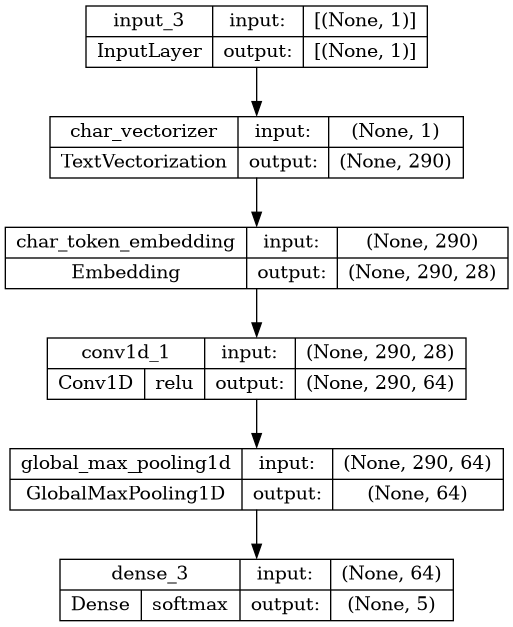

In [93]:
# modelio diagramos sudarymas
from keras.utils import plot_model
plot_model(model_3, show_shapes=True, show_layer_activations=True, to_file="model-img/m3.png")

### Modelio mokymas

In [94]:
# atliekam modelio mokinimą naudojant tik 10% duomenų paketų (batches)
model_3_history = model_3.fit(train_chars_dataset,
                              steps_per_epoch=int(0.1*len(train_chars_dataset)),
                              epochs=5,
                              validation_data=val_chars_dataset,
                              validation_steps=int(0.1*len(val_chars_dataset)),
                              callbacks=[tf.keras.callbacks.TensorBoard(log_dir="tensorboard")])

Epoch 1/5
562/562 [==============================] - 5s 6ms/step - loss: 1.2697 - accuracy: 0.4794 - val_loss: 1.0525 - val_accuracy: 0.5758
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.0059 - accuracy: 0.5978 - val_loss: 0.9344 - val_accuracy: 0.6346
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.9262 - accuracy: 0.6368 - val_loss: 0.8668 - val_accuracy: 0.6662
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8755 - accuracy: 0.6600 - val_loss: 0.8416 - val_accuracy: 0.6689
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8566 - accuracy: 0.6679 - val_loss: 0.8182 - val_accuracy: 0.6895


### Modelio vertinimas

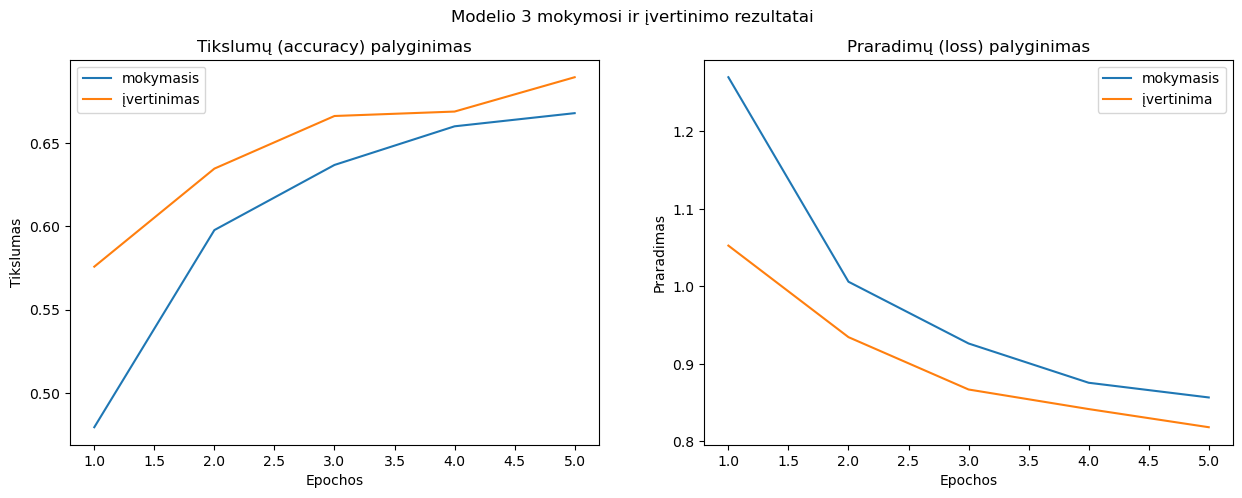

In [95]:
# sudarom modelio "Modelis 3" vertinimo diagramas
plot_accuracy_loss_curves(model_3_history, "3")

In [96]:
# įvertinam modelį su visais testavimo rinkinio pavyzdžiais
loss, accuracy = model_3.evaluate(test_chars_dataset)
print(f"Modelio 3 tikslumas su testavimo duomenimis: {(accuracy*100):.2f}%")

942/942 [==============================] - 4s 4ms/step - loss: 0.8419 - accuracy: 0.6767
Modelio 3 tikslumas su testavimo duomenimis: 67.67%


><br>
><b>Modelis 3</b> klasifikuoja santraukų sakinius ~67% tikslumu, tai kol kas prasčiausias rezultatas iš kolkas sukurtų modelių.<br>
><br>

### Modelio palyginimas su baziniu modeliu

In [97]:
#  paruošiam Modelis 3 rezultatus klasifikacijos rezultatų spausdinimui
model_3_pred_probabilities = model_3.predict(test_chars_dataset) # gaunam modelio tikimybes kiekvienai etiketei
model_3_pred = tf.argmax(model_3_pred_probabilities, axis=1) # randam didžiausios tikimybės indeksą

942/942 [==============================] - 3s 3ms/step


In [98]:
# spausdinam klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_3_pred, model_name="3")

Modelio 3 klasifikacijos rezultatai:
	Accuracy: 67.67%
	Precision: 67.83%
	Recall: 67.67%
	F1 score: 67.26%


In [99]:
# spausdinam bazinio modelio klasifikacijos rezultatą
print_classification_results(y_true=y_test, y_pred=model_0_pred, model_name="Bazinis")

Modelio Bazinis klasifikacijos rezultatai:
	Accuracy: 71.67%
	Precision: 71.24%
	Recall: 71.67%
	F1 score: 69.25%


><br>
><b>Modelio 3</b> klasifikacijos rezultatai, lyginant su Baziniu modeliu, suprastėjo ~4%, lyginant su geriasia rezultatą paseikusiu modeliu Modelis 1, tikslumas suprastėjo ~12%.<br>
><br>

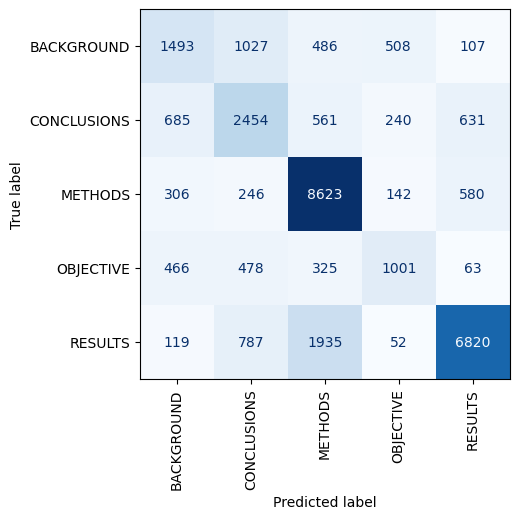

In [100]:
# Modelis 3 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_3_pred, display_labels=etiketes)

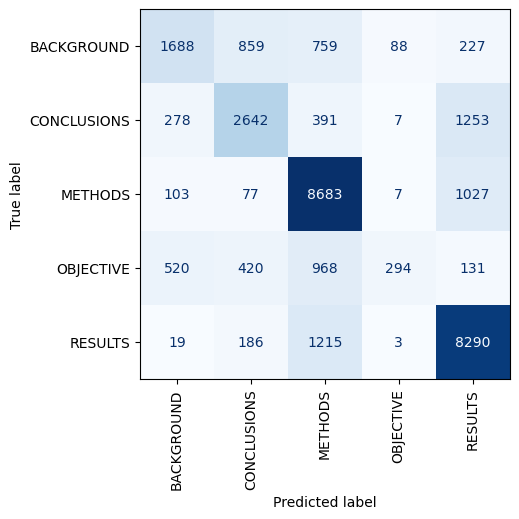

In [101]:
# Modelis 0 spėjimų (confusion) matrica
plot_confusion_matrix(y_true=y_test, y_pred=model_0_pred, display_labels=etiketes)

><br>
>Pagal spėjimų (<i>confusion</i>) matricas <b>Modelis 3</b> pradėjo žymiai prasčiau klasifikuoti <b>RESULTS</b> etikėtę (net prasčiau nei Modelis 2). Daugiau sakinių pradėjo klasifikuoti kaip <b>CONCLUSIONS</b> ir <b>METHODS</b>.<br>
><br>

---